# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Conv1D, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

from matplotlib import pyplot as plt
from matplotlib import rcParams

import sys
import time

sys.path.append("../../../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 15
num_lstm_neurons = 256
num_pre_out_neurons = 256
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_test = all_data["simple_terms"].tolist()
# LO has fewer steps -> 0
# RI has fewer steps -> 1
# LO == RI -> 2
y_test = [2 if los == ris else 1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count TESTING samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

max RI steps count: 1000
max LO steps count: 219
Count TESTING samples: 4251


In [5]:
all_data = pd.read_csv("../article_models_reduct_steps_by_simple_str/data_steps/steps_simple_term_str_extended.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)
all_data = all_data.drop_duplicates(["simple_terms"])

print(f"max RI steps count: {max(all_data['RI_steps_num'])}")
print(f"max LO steps count: {max(all_data['LO_steps_num'])}")

x_train = all_data["simple_terms"].tolist()
# LO has fewer steps -> 0
# RI has fewer steps -> 1
# LO == RI -> 2
y_train = [2 if los == ris else 1 if los > ris else 0 for los, ris in zip(all_data["LO_steps_num"].tolist(), all_data["RI_steps_num"].tolist())]

print(f"Count TRAINING samples: {len(y_train)}")

Count all terms: 44568

Count original terms: 44568

max RI steps count: 1000
max LO steps count: 1000
Count TRAINING samples: 44568


In [6]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 3))
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

# x_train = pad_trunk(x_train)
# x_test = pad_trunk(x_test)

In [7]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [8]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 4251
len(train_data) = 44568


In [9]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def val_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [11]:
from keras.layers import Input
from keras.models import Model

model = Sequential()
model.add(Input(shape=(None, onehot_dims)))
model.add(LSTM(units=num_lstm_neurons))
model.add(Dense(units=num_pre_out_neurons, activation="relu"))
model.add(Dense(units=3, activation="softmax", name="cl_out"))

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               267264    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 cl_out (Dense)              (None, 3)                 771       
                                                                 
Total params: 333,827
Trainable params: 333,827
Non-trainable params: 0
_________________________________________________________________


In [13]:
model_structure = model.to_json()
with open("./fine_models/lstm_model_ext.json", 'w') as json_file:
    json_file.write(model_structure)

In [14]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/lstm_model_ext.h5',  # Specify the path to save the best model
    monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [15]:
history = model.fit(train_generator(), steps_per_epoch=len(xy_train_data), validation_data=val_generator(), validation_steps=len(xy_test_data),
                    epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/15
44568/44568 [==============================] - 1186s 27ms/step - loss: 0.8609 - accuracy: 0.6276 - val_loss: 0.6920 - val_accuracy: 0.7309
Epoch 2/15
44568/44568 [==============================] - 1186s 27ms/step - loss: 0.7423 - accuracy: 0.7006 - val_loss: 0.6971 - val_accuracy: 0.7337
Epoch 3/15
44568/44568 [==============================] - 1188s 27ms/step - loss: 0.6610 - accuracy: 0.7370 - val_loss: 0.5798 - val_accuracy: 0.7638
Epoch 4/15
44568/44568 [==============================] - 1235s 28ms/step - loss: 0.5762 - accuracy: 0.7612 - val_loss: 0.5807 - val_accuracy: 0.7777
Epoch 5/15
44568/44568 [==============================] - 1345s 30ms/step - loss: 0.5191 - accuracy: 0.7857 - val_loss: 0.5976 - val_accuracy: 0.7822
Epoch 6/15
44568/44568 [==============================] - 1245s 28ms/step - loss: 0.4740 - accuracy: 0.8095 - val_loss: 0.6421 - val_accuracy: 0.7960
Epoch 7/15
44568/44568 [==============================] - 1167s 26ms/step - loss: 0.4458 - accuracy:

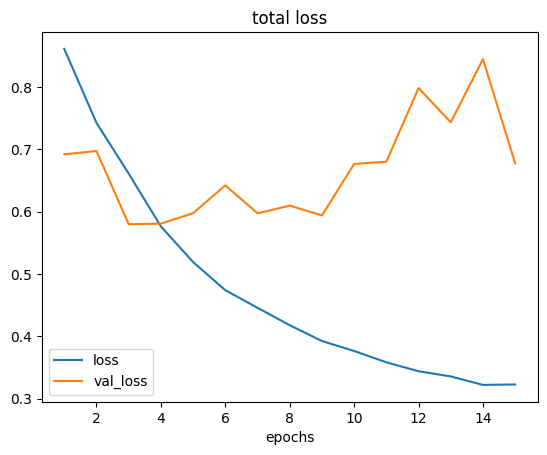

In [16]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.plot(range(1, epochs + 1), history.history['val_loss'], label="val_loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

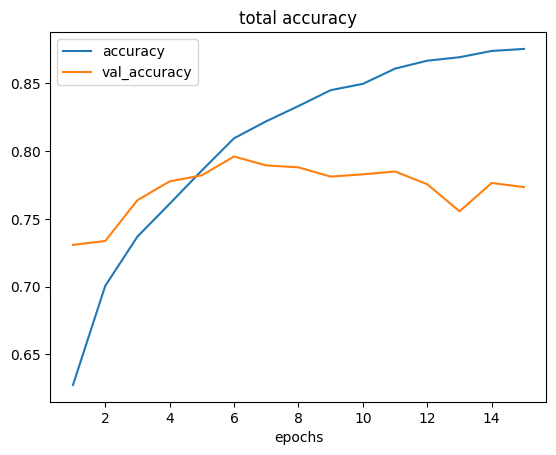

In [17]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label="val_accuracy")
plt.xlabel("epochs")
plt.title("total accuracy")

plt.legend()
plt.show()

In [10]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes, class_labels, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix of a classification model.

    Args:
        y_true (numpy.ndarray): The ground truth labels.
        y_pred (numpy.ndarray): The predicted labels.
        classes (list): The list of class labels.
        class_labels: The list of class names.
        normalize (bool, optional): Whether to normalize the confusion matrix. Defaults to False.
        title (str, optional): The title of the plot. Defaults to None.
        cmap (matplotlib.colors.Colormap, optional): The colormap to use for the plot. Defaults to plt.cm.Blues.
    """

    cm = confusion_matrix(y_true, y_pred, labels=classes)

    if normalize:
        cm = confusion_matrix(y_true, y_pred, labels=classes).astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(title)
    fig.colorbar(im)

    thresh = cm.max() / 2.
    for i in range(len(classes)):
        for j in range(len(classes)):
            ij = float(cm[i, j])
            ax.text(j, i, f"{ij:.2f}", ha='center', va='center', color='white' if ij > thresh else 'black')

    plt.tight_layout()
    plt.show()

In [9]:
# load the model

with open("./fine_models/lstm_model_ext.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights("./fine_models/lstm_model_ext.h5")

100%|██████████| 4251/4251 [04:33<00:00, 15.57it/s]


Test accuracy: 0.7960479887085392


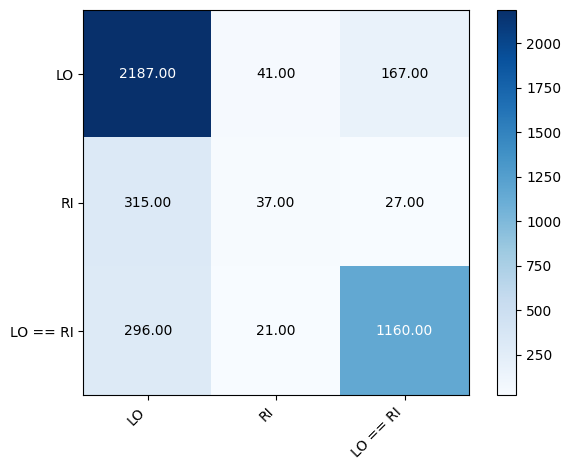

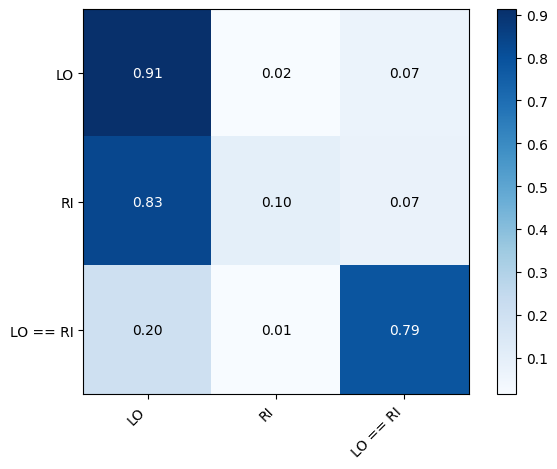

In [20]:
y_test_pred = []
for x_ in tqdm(x_test):
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1, 2], class_labels=["LO", "RI", "LO == RI"])
plot_confusion_matrix(y_test_nums, y_test_pred_nums, classes=[0, 1, 2], class_labels=["LO", "RI", "LO == RI"], normalize=True)

100%|██████████| 44568/44568 [53:56<00:00, 13.77it/s]  


Train accuracy: 0.8193322563274098


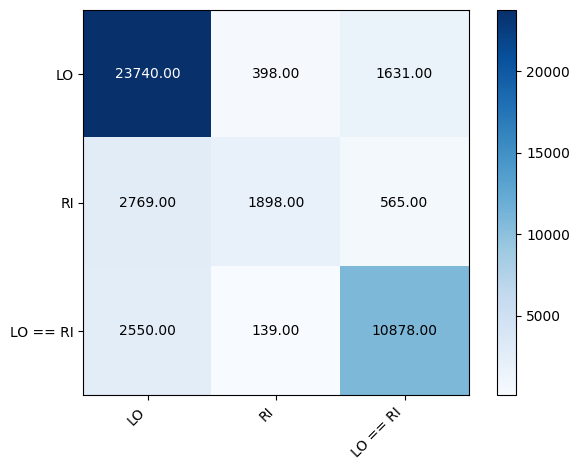

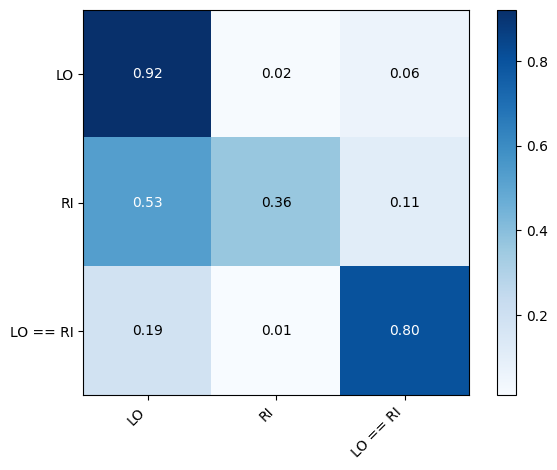

In [11]:
y_train_pred = []
for x_ in tqdm(x_train):
    res_ = encoder.inverse_transform(np.array([model.predict(np.array([x_]), verbose=0)[0],]))[0]
    y_train_pred.append(res_)

y_train_pred_nums =y_train_pred
y_train_nums = encoder.inverse_transform(y_train)

print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1, 2], class_labels=["LO", "RI", "LO == RI"])
plot_confusion_matrix(y_train_nums, y_train_pred_nums, classes=[0, 1, 2], class_labels=["LO", "RI", "LO == RI"], normalize=True)

# Do additional metrics testing

In [12]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    simple_str = term_.simple_str()
    prediction_ = model_.predict(np.array(tokenize_and_vectorize([simple_str])), verbose=0)
    los = term_.normalize(LOStrategy())[1]
    ris = term_.normalize(RIStrategy())[1]
    res_real = 2 if los == ris else 1 if los > ris else 0
    class_labels = ["LO", "RI", "LO == RI"]
    print(f"{term_deskr_}\nbest real -> {class_labels[res_real]}\tbest pred -> {class_labels[np.argmax(prediction_[0])]}\n")


list_test_functions = (
term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10,
term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
best real -> LO	best pred -> LO

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
best real -> LO == RI	best pred -> LO == RI

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
best real -> LO == RI	best pred -> LO == RI

(PRED 0) == 0 == λx. λy. y
best real -> LO == RI	best pred -> LO == RI

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
best real -> LO == RI	best pred -> RI

(PLUS 0 0) == 0 == λx. λy. y
best real -> LO == RI	best pred -> LO == RI

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
best real -> LO == RI	best pred -> LO == RI

(SUBTRACT 3 5) == 0 == λx. λy. y
best real -> LO == RI	best pred -> RI

(LEQ 3 2) == FALSE == λx. λy. y
best real -> LO	best pred -> LO

(LEQ 2 5) == TRUE == λx. λy. x
best real -> LO == RI	best pred -> RI

(EQ 2 2) == TRUE == λx. λy. x
best real -> LO	best pred -> LO

(EQ 1 4) == FALSE == λx. λy. y
best real -> LO	best pred -> LO

Omega(3, 3)  == I == λx. x
best real -> RI	best pred -> RI

GCD_vO 5 2
best